In [1]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms,datasets
from PIL import Image
import timeit
from skimage import io, transform
import os
from torch.utils.data import Dataset
import math

<center>All the images have been moved to single folder and the excel containing data is moved out from it. All these files including the notebook are in one single folder but i have only submitted the ipynb file from in here.</center>


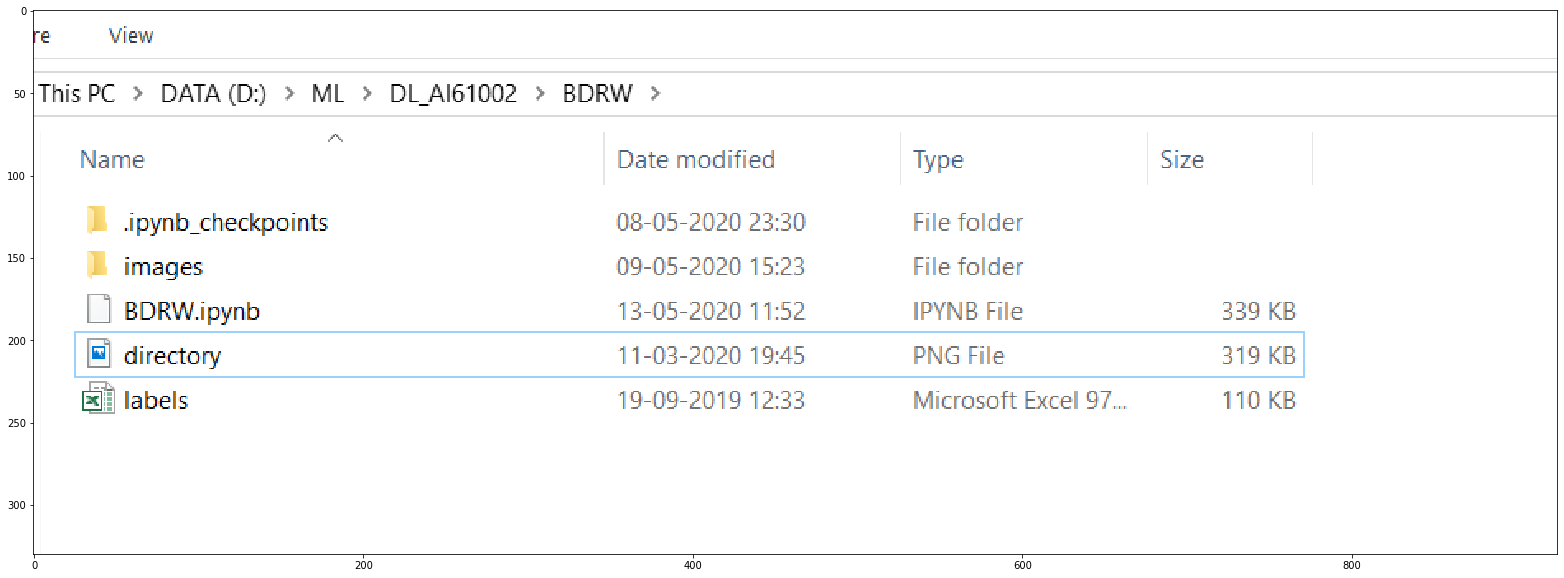

In [2]:
plt.figure(figsize=(200,10))
plt.imshow(io.imread(os.path.join('D:\ML\DL_AI61002\BDRW\directory.png')))
plt.show()

In [3]:
df = pd.read_excel("labels.xls",header = None)
df.head()

all_labels = pd.unique(df[1])
label_count = df[1].value_counts()

test_proportion = 393/1393

img_name = df[0]
digit_value = df[1]

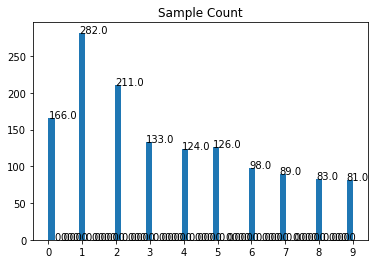

In [4]:
arr=plt.hist(df[1],bins=50)
for i in range(50):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.xticks(np.arange(10))
plt.title("Sample Count")
plt.show()

<center>Class imbalance can be clearly observed for our data, therefore used proportionate selection for test data to maintain ratio of all classes in train and test data. Methods to handle this imbalance are stated further below.</center>

In [5]:
temp = int(label_count[9]*test_proportion)
test_df = df[df[1]==9].sample(temp)
for i in range(len(all_labels-1)):
    temp = int(label_count[i]*test_proportion)
    test_df = test_df.append(df[df[1]==i].sample(temp))
test_df = test_df.iloc[:393]
test_df = test_df.sample(frac = 1)

In [6]:
train_df = df
for i in test_df.index:
    if(i in train_df.index):
        train_df.drop(i,inplace=True,axis=0)
train_df = train_df.iloc[:1000]
train_df = train_df.sample(frac = 1)

train_df.reset_index(drop=True,inplace = True)
test_df.reset_index(drop=True,inplace = True)

<center>TRAIN :1000 samples(800/200 5 fold) ||
TEST : 393 samples</center>

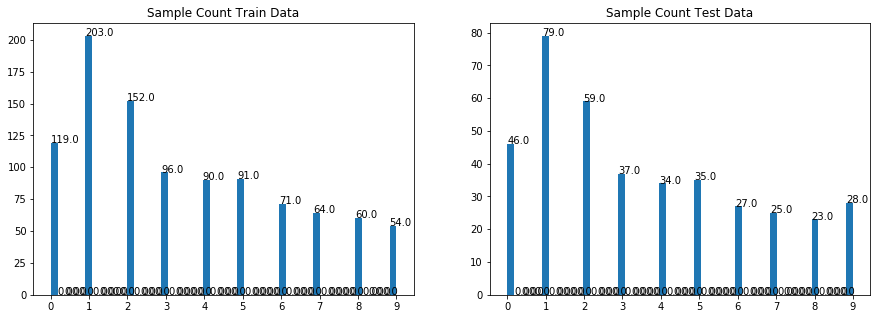

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
arr1=plt.hist(train_df[1],bins=50)
for i in range(50):
    plt.text(arr1[1][i],arr1[0][i],str(arr1[0][i]))
plt.xticks(np.arange(10))
plt.title("Sample Count Train Data")
plt.subplot(122)
arr2=plt.hist(test_df[1],bins=50)
for i in range(50):
    plt.text(arr2[1][i],arr2[0][i],str(arr2[0][i]))
plt.xticks(np.arange(10))
plt.title("Sample Count Test Data")
plt.show()

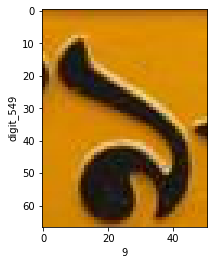

In [8]:
#Function to display samples

def show_img(image_name,image, digit):
    
    plt.ylabel(image_name)
    plt.xlabel(digit)
    plt.imshow(image)

plt.figure()
sample_number = 500
show_img(img_name[sample_number],io.imread(os.path.join('D:\ML\DL_AI61002\BDRW\images/new/', img_name[sample_number]+'.jpg')),
               digit_value[sample_number])
plt.show()

<center> Now, Function definition for making dataset with images converted to tensors ,and labels by integrating all our images and excel sheet data</center>

In [9]:


class bdrw_dataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.digits_frame = dataframe               #can be used by reading file here instead of directly taking dataframe as input
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.digits_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.digits_frame.iloc[idx, 0]+'.jpg')
        image = io.imread(img_name)
        image = Image.fromarray(np.uint8((image)*255))
    
        
        digits = self.digits_frame.iloc[idx, 1]
        digits = np.array([digits])
#        digits = torch.from_numpy(digits)
        if self.transform:
            image = self.transform(image)

        return image,digits    

<center>Preparation of train/test sets using the defined function</center>

In [10]:
batch_size = 32
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_set = bdrw_dataset(train_df,'D:\ML\DL_AI61002\BDRW\images/new',transform = transform)
test_set = bdrw_dataset(test_df,'D:\ML\DL_AI61002\BDRW\images/new',transform = transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [11]:
use_gpu = torch.cuda.is_available()

if use_gpu:
    print('GPU is avaialble!')
    
else :
    print("Not Available")

GPU is avaialble!


In [12]:
dropout_prob = 0.4

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv1_drop = nn.Dropout2d(p=dropout_prob)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=dropout_prob)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(400, 120)
        self.fc1_drop = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(120, 84)
        self.fc1_drop = nn.Dropout(p=dropout_prob)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)
net = LeNet()
net = net.cuda()
print(net)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1_drop): Dropout2d(p=0.4, inplace=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.4, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [13]:
from pytorch_model_summary import summary


# show input shape
print(summary(LeNet(), torch.zeros((3, 3, 32, 32)), show_input=True))

# show output shape and hierarchical view of net
print(summary(LeNet(), torch.zeros((3, 3, 32, 32)), show_input=False, show_hierarchical=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [3, 3, 32, 32]             456             456
       MaxPool2d-2      [3, 6, 28, 28]               0               0
          Conv2d-3      [3, 6, 14, 14]           2,416           2,416
       MaxPool2d-4     [3, 16, 10, 10]               0               0
          Linear-5            [3, 400]          48,120          48,120
          Linear-6            [3, 120]          10,164          10,164
          Linear-7             [3, 84]             850             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
-----------------------------------------------------------------------
-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Conv2d-1      [3, 6, 28, 28]             456             456
    

In [14]:
#choosing all other attributes an methods for training

from torch import optim


learning_rate=0.005
num_epochs=10
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate,weight_decay=0.025) 


<center>We do not have large amount of samples and class imbalance also appeared in our data. To compensate these, 5 fold cross validation has been done to achieve better learning of all class features and Negative Log Likelihood loss function is implied. And to avoid overfitting, several dropout layers has been defined with the model and used L2 regularization in from of weight decay.</center>

In [15]:
from sklearn.model_selection import KFold

kf = KFold(5)

fold_count = 0
folds = 5
train_loss = [[]*folds]*num_epochs
train_acc = [[]*folds]*num_epochs
valid_loss = [[]*folds]*num_epochs
valid_acc = [[]*folds]*num_epochs

dataset_sizes = pd.DataFrame({'train':[800],'valid':[200]})

<center>The previously trained model is used for every next fold of training and validation. Learning rate is being decayed every epoch and scheduled with initial lr for each fold. Thus lr is same while training for any single epoch. 
</center>

In [16]:
start = timeit.default_timer()
for train_idx, valid_idx in kf.split(train_df):
        
        
        train_fold_df = train_df.iloc[train_idx].copy()
        valid_fold_df = train_df.iloc[valid_idx].copy()
        
        train_fold_df.reset_index(drop=True,inplace=True)
        valid_fold_df.reset_index(drop=True,inplace=True)
        
        train_fold = bdrw_dataset(train_fold_df,'D:\ML\DL_AI61002\BDRW\images/new',transform = transform)
        valid_fold = bdrw_dataset(valid_fold_df,'D:\ML\DL_AI61002\BDRW\images/new',transform = transform)

        #dataloaders for training have been created after splitting data for validation during each fold.
        
        trainloader = torch.utils.data.DataLoader(train_fold, batch_size=batch_size, shuffle=True)
        validloader = torch.utils.data.DataLoader(valid_fold, batch_size=batch_size, shuffle=True)

        best_model_wts = net.state_dict()
        best_acc = 0

        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

        
        print('FOLD ',fold_count+1,'\n')
            
        
        for epoch in range(num_epochs):
                    
                    
                        for phase in ['train','valid']:
                            if phase == 'train':
                                net.train(True)
                                dataloader = trainloader
                                
                            
                            else:
                                net.train(False)
                                dataloader = validloader

                            running_loss = 0.0 
                            running_corr = 0
                    
                            
                            for i,data in enumerate(dataloader):
                                inputs,labels = data
                                labels=labels.squeeze()

                                if use_gpu:
                                    inputs = inputs.cuda()
                                    labels = labels.cuda()


                                #Initializing model gradients to zero
                                if phase == 'train':
                                    net.zero_grad()
                                    optimizer.zero_grad() 

                                # Data feed-forward through the network
                                outputs = net(inputs)

                                # Predicted class is the one with maximum probability
                                preds = torch.argmax(outputs,dim=1)

                                # Finding the loss
                                loss = criterion(outputs, labels)

                                if phase=='train':
                                    loss.backward()
                                    optimizer.step()
                                        
                                    
                                # Accumulating the loss for each batch
                                running_loss += loss 
                                # Accumulate number of correct predictions
                                running_corr += torch.sum(preds==labels)    

                            #totalLoss = running_loss/(i+1)
                            # Calculating gradients


                            # Updating the model parameters
                            for f in net.parameters():
                                f.data.sub_(f.grad.data * learning_rate)

                            epoch_loss = running_loss.item()/dataset_sizes[phase]   #Total loss for one epoch
                            epoch_acc = running_corr.item()/dataset_sizes[phase]

                            if phase =='valid' and epoch_acc.item() > best_acc:
                                best_acc = epoch_acc.item()
                                best_model_wts = net.state_dict()

                            if phase == 'train':
                                train_loss[fold_count].append(epoch_loss) #Saving the loss over epochs for plotting the graph
                                train_acc[fold_count].append(epoch_acc) #Saving the accuracy over epochs for plotting the graph
                                print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f} '.format(epoch+1,num_epochs,epoch_loss.item(),epoch_acc.item()))


                            else:
                                valid_loss[fold_count].append(epoch_loss)
                                valid_acc[fold_count].append(epoch_acc)
                                print('Epoch {:.0f}/{:.0f} : Validation loss: {:.4f} | Validation Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss.item(),epoch_acc.item()))
                        
                        scheduler.step()       
                        
        fold_count = fold_count + 1
        print("\n")

print("\nTotal Training time = ",timeit.default_timer()-start,' seconds')


FOLD  1 

Epoch 1/10 : Training loss: 0.0700 | Training Accuracy: 0.1900 
Epoch 1/10 : Validation loss: 0.0760 | Validation Accuracy: 0.2450
Epoch 2/10 : Training loss: 0.0641 | Training Accuracy: 0.2687 
Epoch 2/10 : Validation loss: 0.0681 | Validation Accuracy: 0.2550
Epoch 3/10 : Training loss: 0.0558 | Training Accuracy: 0.3212 
Epoch 3/10 : Validation loss: 0.0574 | Validation Accuracy: 0.3650
Epoch 4/10 : Training loss: 0.0434 | Training Accuracy: 0.5088 
Epoch 4/10 : Validation loss: 0.0386 | Validation Accuracy: 0.6050
Epoch 5/10 : Training loss: 0.0320 | Training Accuracy: 0.6488 
Epoch 5/10 : Validation loss: 0.0306 | Validation Accuracy: 0.7100
Epoch 6/10 : Training loss: 0.0223 | Training Accuracy: 0.7700 
Epoch 6/10 : Validation loss: 0.0197 | Validation Accuracy: 0.8100
Epoch 7/10 : Training loss: 0.0167 | Training Accuracy: 0.8500 
Epoch 7/10 : Validation loss: 0.0178 | Validation Accuracy: 0.8350
Epoch 8/10 : Training loss: 0.0137 | Training Accuracy: 0.8675 
Epoch 8/1

In [17]:
train_loss = np.array(train_loss)[0]
train_loss = train_loss.reshape((5,num_epochs))
valid_loss = np.array(valid_loss)[0]
valid_loss = valid_loss.reshape((5,num_epochs))
train_acc = np.array(train_acc)[0]
train_acc = train_acc.reshape((5,num_epochs))
valid_acc = np.array(valid_acc)[0]
valid_acc= valid_acc.reshape((5,num_epochs))

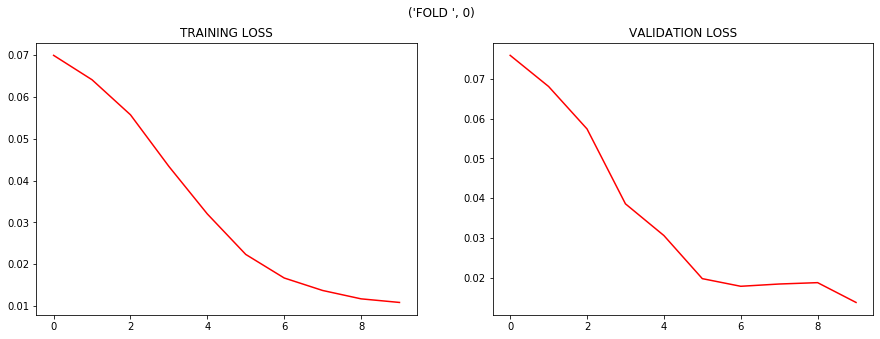

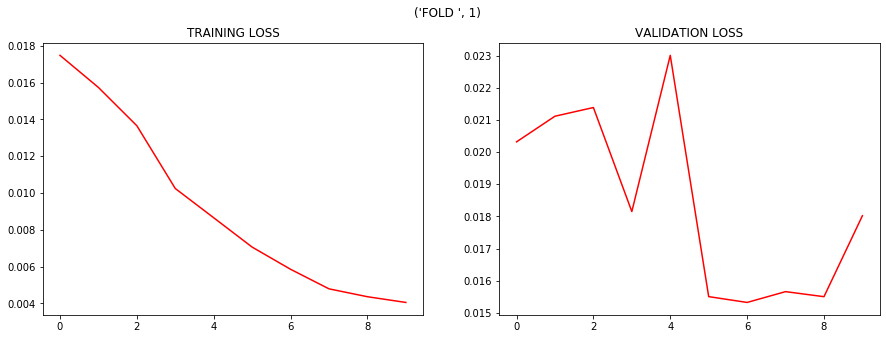

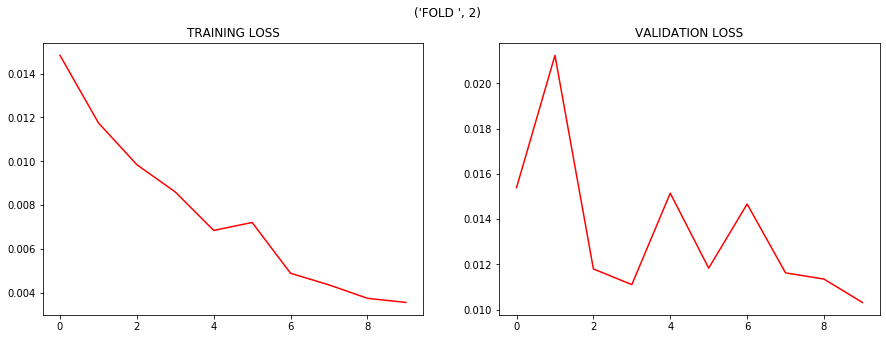

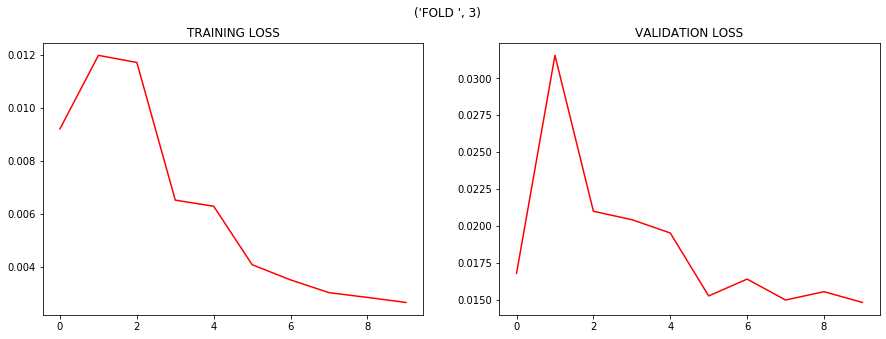

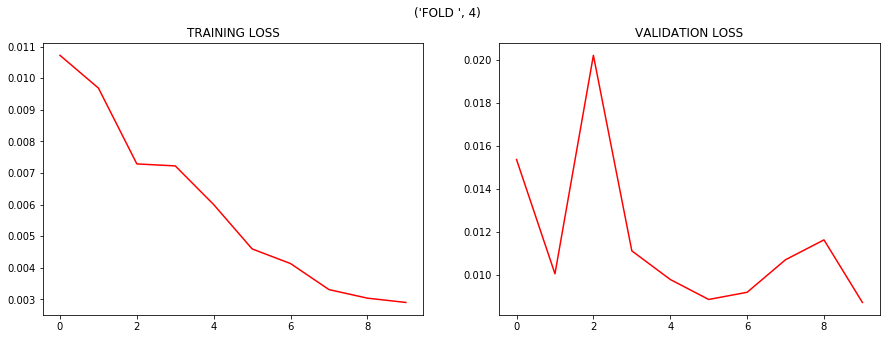

In [18]:
for i in range(folds):
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(num_epochs),train_loss[i],'r')
    plt.title("TRAINING LOSS")
    plt.subplot(122)
    plt.plot(range(num_epochs),valid_loss[i],'r')
    plt.title("VALIDATION LOSS")
    plt.suptitle(('FOLD ',i))

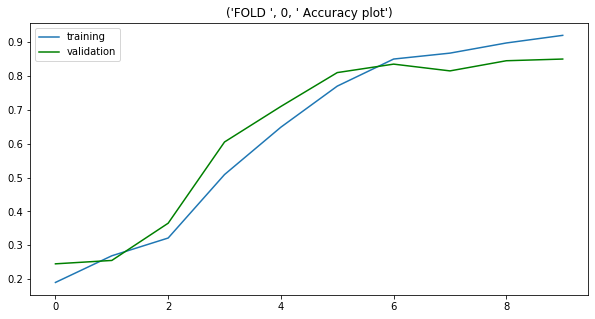

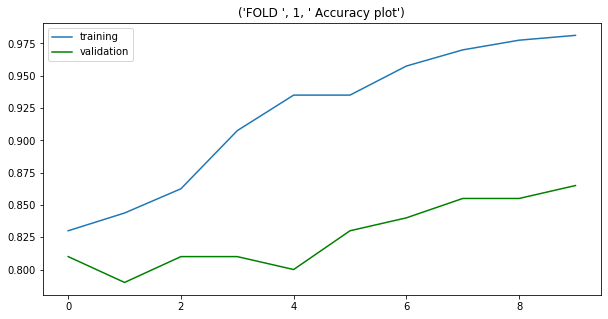

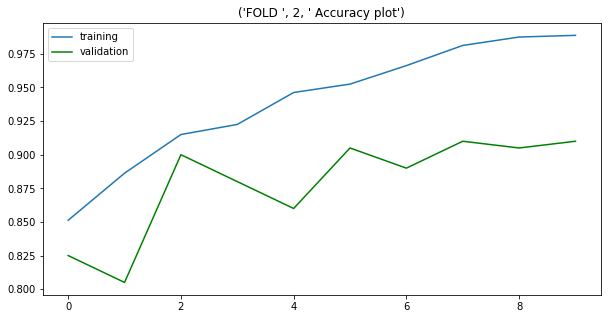

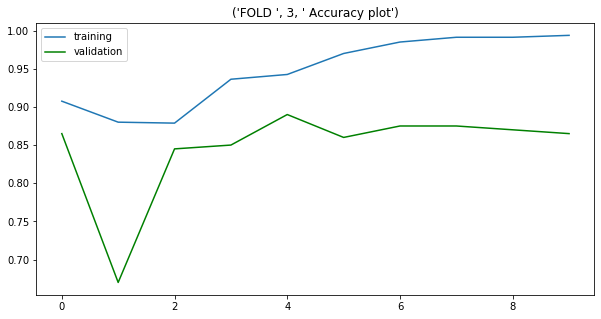

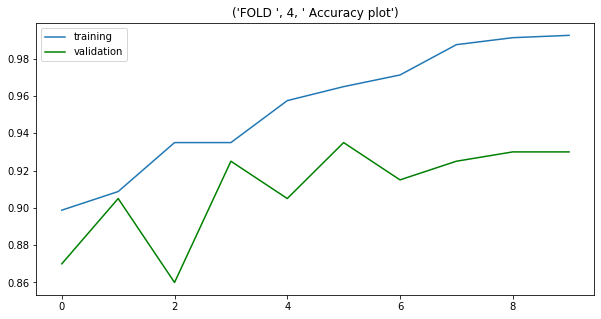

In [19]:
for i in range(folds):
    plt.figure(figsize =(10,5))

    plt.plot(range(num_epochs),train_acc[i])
    plt.plot(range(num_epochs),valid_acc[i],'g')
    plt.title(('FOLD ',i," Accuracy plot"))
    plt.legend(('training','validation'))

In [20]:
#Predicting labels of our test data

test_pred = torch.LongTensor().cuda()
for i,data in enumerate(testloader):
    inputs,labels = data
    if use_gpu:
        inputs, labels = inputs.cuda(),labels.cuda()
    # Feedforward train data batch through model
    output = net(inputs) 
    # Predicted class is the one with maximum probability
    preds = torch.argmax(output,dim=1)
    test_pred = torch.cat((test_pred, preds), dim=0)


In [21]:
correct_pred = 0
for i in range(len(test_df[1])):
    if(test_pred[i]==test_df[1][i]):
        correct_pred += 1
print('TESTING ACCURACY =',100*(correct_pred/len(test_df[1])))

TESTING ACCURACY = 96.18320610687023
